In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
from ecoevocrm.consumer_resource_system import *
from ecoevocrm.landscapes import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg
import ecoevocrm.strain_pool

In [3]:
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns

----

## Model parameters

### Traits

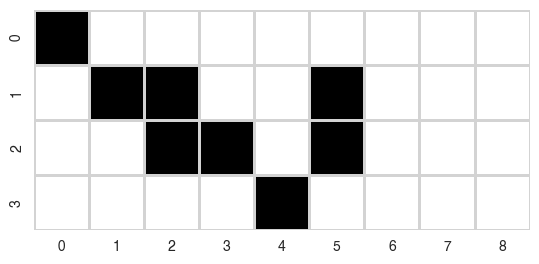

In [4]:
                       # h  h  h  h  h   t   m  m  m
traits_init = np.array([[1, 0, 0, 0, 0,  0,  0, 0, 0],   # pf|A
                        [0, 1, 1, 0, 0,  1,  0, 0, 0],   # pc|A
                        [0, 0, 1, 1, 0,  1,  0, 0, 0],   # pc|B
                        [0, 0, 0, 0, 1,  0,  0, 0, 0]])  # pf|B
viz.matrix_plot(traits_init, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

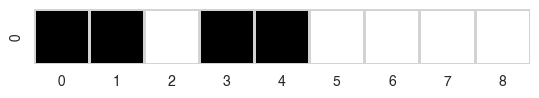

In [5]:
h = 1
consumption_rates = np.array([h, h, 0, h, h, 0, 0, 0, 0])  # for all types
viz.matrix_plot(consumption_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

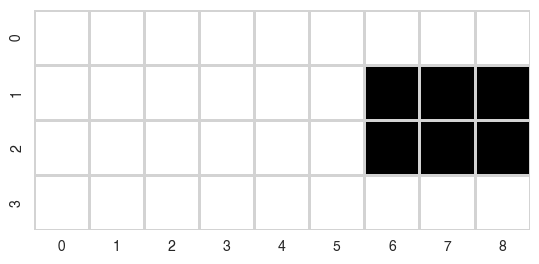

In [6]:
m = 1e-9  # TODO make get_dynamics_params work when mutation rate is 0, etc
mutation_rates = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],   # pf|A 
                           [0, 0, 0, 0, 0, 0, m, m, m],   # pc|A
                           [0, 0, 0, 0, 0, 0, m, m, m],   # pc|B
                           [0, 0, 0, 0, 0, 0, 0, 0, 0]])  # pf|B
viz.matrix_plot(mutation_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

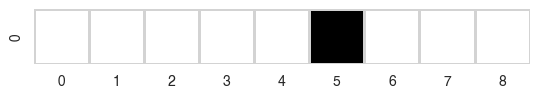

In [7]:
l = 1e-9
segregation_rates = np.array([0, 0, 0, 0, 0, l, 0, 0, 0])  # for all types
viz.matrix_plot(segregation_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

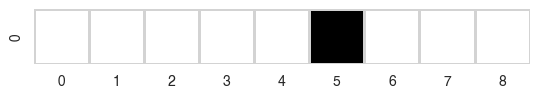

In [8]:
b = 1e-12
a = 1
transfer_donor_rates = np.array([0, 0, 0, 0, 0, b, 0, 0, 0])  # for all types
transfer_recip_rates = np.array([0, 0, 0, 0, 0, a, 0, 0, 0])  # for all types
viz.matrix_plot(transfer_donor_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)
viz.matrix_plot(transfer_recip_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [9]:
                       #  parent:     { attributes of segregants }
segregant_attributes = { '011000...': {'traits': np.array([1, 0, 0, 0, 0, 0, 0, 0, 0]), 'mutation_rate': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])},
                         '001100...': {'traits': np.array([0, 0, 0, 0, 1, 0, 0, 0, 0]), 'mutation_rate': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])} }

In [10]:
linkage = {5: [6, 7, 8]}

In [11]:
N_init = np.ones(traits_init.shape[0])
N_init

array([1., 1., 1., 1.])

### Costs

In [12]:
cost_baseline = 0.1

In [13]:
N = 3
K = 0

In [14]:
landscape_hostA = NKLandscape(N=N, K=K, seed=67)
display(landscape_hostA.genotype_fitnesses)

{'000': 0.8040561057067969,
 '001': 0.7875642314646695,
 '010': 0.6465308714882542,
 '011': 0.6300389972461269,
 '100': 0.7389835549496024,
 '101': 0.7224916807074752,
 '110': 0.5814583207310596,
 '111': 0.5649664464889325}

In [15]:
landscape_hostB = NKLandscape(N=N, K=K, seed=858)
display(landscape_hostB.genotype_fitnesses)

{'000': 0.7315685487395694,
 '001': 0.6408336836099634,
 '010': 0.5257349589995871,
 '011': 0.435000093869981,
 '100': 0.6259306511991731,
 '101': 0.5351957860695671,
 '110': 0.4200970614591908,
 '111': 0.3293621963295848}

In [16]:
landscape = merge_landscapes(landscape_hostA.genotype_fitnesses, landscape_hostB.genotype_fitnesses, prefix_A='011001', prefix_B='001101')  # prefixes = traits for pc|A and pc|B

In [17]:
landscape.update({'100000000': max(landscape_hostA.genotype_fitnesses.values()),   # pf|A
                  '000010000': max(landscape_hostB.genotype_fitnesses.values())})  # pf|B

In [18]:
landscape

{'011001000': 0.8040561057067969,
 '011001001': 0.7875642314646695,
 '011001010': 0.6465308714882542,
 '011001011': 0.6300389972461269,
 '011001100': 0.7389835549496024,
 '011001101': 0.7224916807074752,
 '011001110': 0.5814583207310596,
 '011001111': 0.5649664464889325,
 '001101000': 0.7315685487395694,
 '001101001': 0.6408336836099634,
 '001101010': 0.5257349589995871,
 '001101011': 0.435000093869981,
 '001101100': 0.6259306511991731,
 '001101101': 0.5351957860695671,
 '001101110': 0.4200970614591908,
 '001101111': 0.3293621963295848,
 '100000000': 0.8040561057067969,
 '000010000': 0.7315685487395694}

### Environment

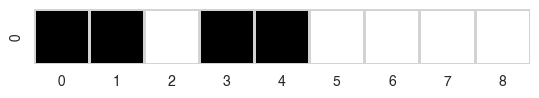

In [19]:
R_init = np.zeros(traits_init.shape[1])
R_init[consumption_rates > 0] = 1
viz.matrix_plot(R_init, vmin=0, vmax=1, cbar=False, linecolor='lightgray', linewidths=1)

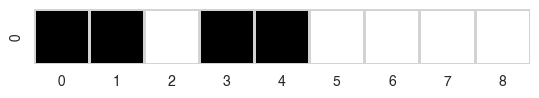

In [20]:
influx_rates = np.zeros(traits_init.shape[1])
influx_rates[consumption_rates > 0] = 1
viz.matrix_plot(influx_rates, vmin=0, cbar=False, linecolor='lightgray', linewidths=1)

In [21]:
decay_rates = 1

In [22]:
carrying_capacity = 1e9

## Simulate model

In [23]:
system = ConsumerResourceSystem(traits=traits_init, 
                                consumption_rate=consumption_rates, carrying_capacity=carrying_capacity, 
                                cost_landscape=landscape, cost_baseline=cost_baseline, 
                                mutation_rate=mutation_rates, segregation_rate=segregation_rates,
                                segregation_linkage=linkage, transfer_linkage=linkage,
                                segregant_attributes=segregant_attributes,
                                influx_rate=influx_rates, decay_rate=decay_rates,
                                N_init=N_init, R_init=R_init, seed=2)

In [24]:
system.type_set.energy_costs

array([0.90405611, 0.90405611, 0.83156855, 0.83156855])

In [25]:
T_total = 1e6

In [26]:
system.run(T=T_total)

[ Mutation event occurred at  t=165.29 ]	
[ Mutation event occurred at  t=225.94 ]	
[ Mutation event occurred at  t=247.67 ]	
[ Mutation event occurred at  t=262.38 ]	
[ Mutation event occurred at  t=270.22 ]	
[ Mutation event occurred at  t=378.38 ]	
[ Mutation event occurred at  t=508.05 ]	
[ Mutation event occurred at  t=514.18 ]	
[ Mutation event occurred at  t=530.61 ]	
[ Mutation event occurred at  t=546.21 ]	
[ Mutation event occurred at  t=643.77 ]	
[ Mutation event occurred at  t=919.85 ]	
[ Mutation event occurred at  t=5865.83 ]	


<AxesSubplot: >

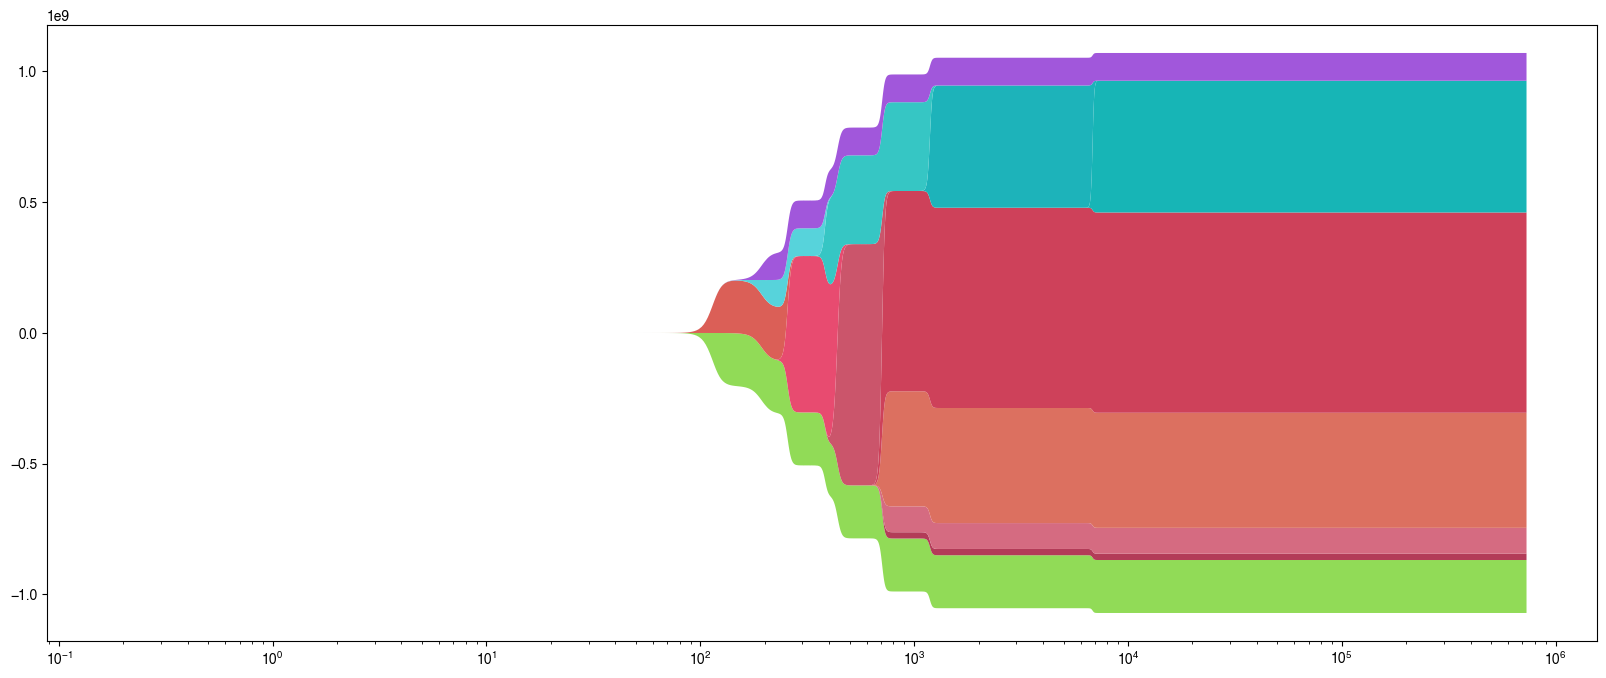

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(system, ax=ax, relative_abundance=False, apply_palette_depth=0, log_x_axis=True, color_seed=1)

<AxesSubplot: >

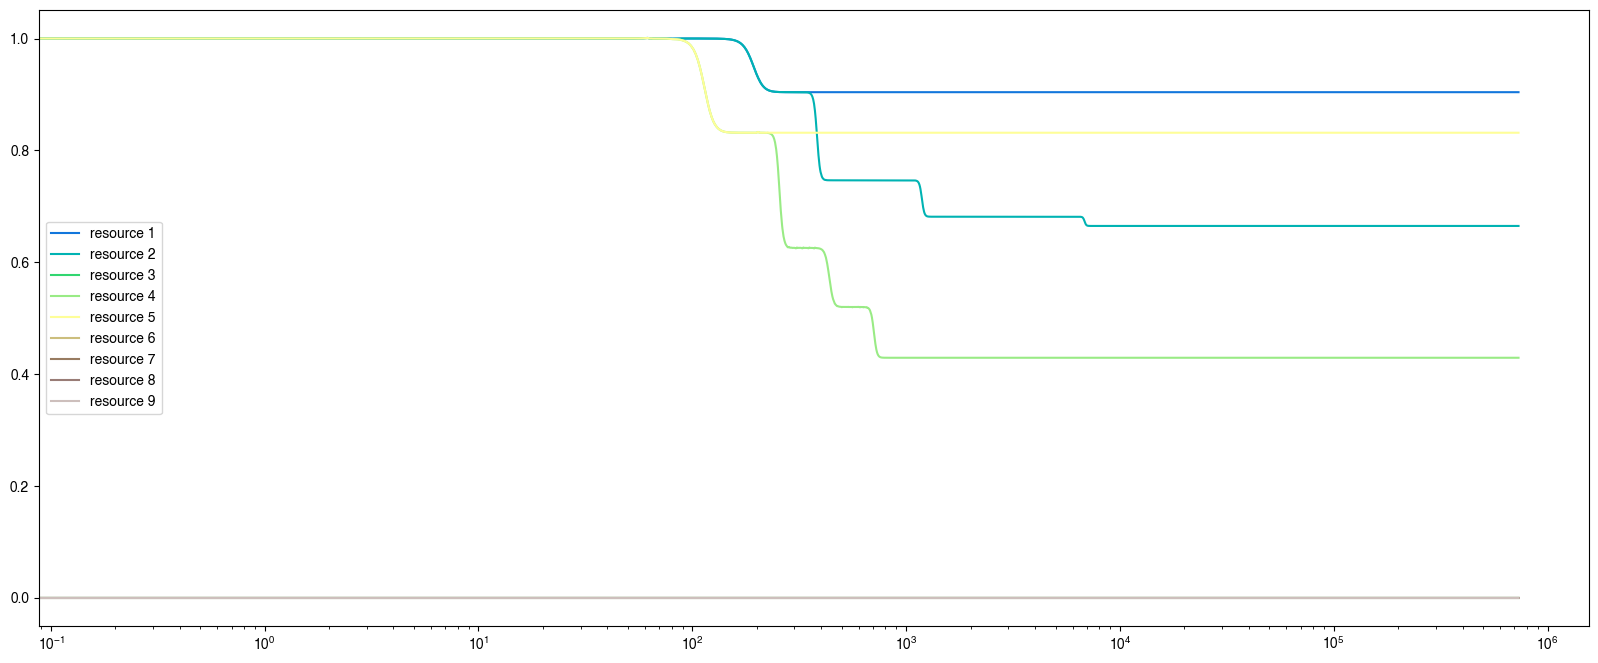

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.resource_plot(system, ax=ax, stacked=False, relative=False, log_x_axis=True, log_y_axis=False)

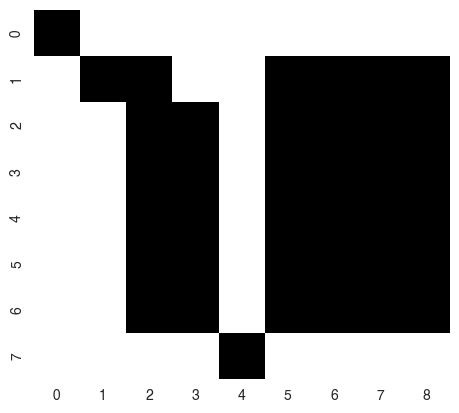

In [29]:
viz.matrix_plot(system.extant_type_set.traits)

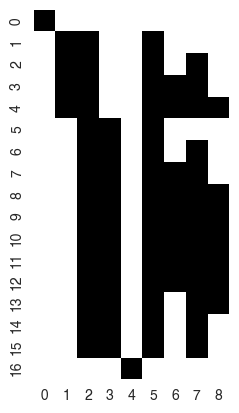

In [30]:
viz.matrix_plot(system.type_set.traits)